In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pickle

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFECV
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from catboost import CatBoostRegressor

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import GroupKFold

In [11]:
def load_data():
    
    B0005 = pd.read_csv('../Data & Outputs/Nasa/B0005_pro.csv')
    B0006 = pd.read_csv('../Data & Outputs/Nasa/B0006_pro.csv')
    B0007 = pd.read_csv('../Data & Outputs/Nasa/B0007_pro.csv')
    B0018 = pd.read_csv('../Data & Outputs/Nasa/B0018_pro.csv')
    
    df = pd.concat([B0005, B0006, B0007, B0018], axis=0)

    # define the mapping between cell names and group numbers
    cell_to_group = {'B0005': 1, 'B0006': 2, 'B0007': 3, 'B0018': 4}
    df['group'] = df['cell'].apply(lambda x: cell_to_group[x])
    groups = list(df['group'].sort_values())
    
    return df, groups

def create_model(regressor):
    
    if regressor == 'RF':
        model = RandomForestRegressor(n_jobs=-1, random_state=42)
    elif regressor == 'XGB':
        model = XGBRegressor(n_jobs=-1, random_state=42)
    elif regressor == 'LGBM':
        model = LGBMRegressor(n_jobs=-1, random_state=42)
    elif regressor == 'CAT':
        model = CatBoostRegressor(silent=True, random_state=42)
    
    return model

def visualize_corr_heatmap(df, regressor):
    
    df = df.drop(['cycle', 'cell', 'group'], axis=1)
    corr = df.corr()
    plt.figure(figsize=(20,10)) 
    sns.heatmap(corr, annot=True, cmap='RdBu', annot_kws={"size": 10, "color": "white"})
    
    plt.show()


def feature_selection_corr(df, regressor, k=2):
    
    X = df.drop(['cycle', 'cell', 'SoH', 'group'], axis=1)
    y = df['SoH']
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)
    top_features_indices = selector.get_support(indices=True)
    corr_features = X.columns[top_features_indices]
    scores = selector.scores_
    selected_mask = selector.get_support()
    colors = ['blue' if selected else 'gray' for selected in selected_mask]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(np.arange(len(scores)), scores, color=colors)
    ax.set_xticks(np.arange(len(scores)))
    ax.set_xticklabels(X.columns, rotation=45)
    ax.set_ylabel('F regression scores')
    selected_features_str = ', '.join(corr_features)
    ax.set_title(f'Feature scores (selected features: {selected_features_str})')
    plt.tight_layout()
    plt.show()
    print(f'Correlation based selected features: {corr_features}')

    return corr_features

def feature_selection_mi(df, regressor, k=2):
    
    X = df.drop(['cycle', 'cell', 'SoH', 'group'], axis=1)
    y = df['SoH']
    selector = SelectKBest(score_func=mutual_info_regression, k=k)
    selector.fit(X, y)
    top_features_indices = selector.get_support(indices=True)
    mi_features = X.columns[top_features_indices]
    scores = selector.scores_
    selected_mask = selector.get_support()
    colors = ['blue' if selected else 'gray' for selected in selected_mask]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(np.arange(len(scores)), scores, color=colors)
    ax.set_xticks(np.arange(len(scores)))
    ax.set_xticklabels(X.columns, rotation=45)
    ax.set_ylabel('Mutual Information scores')  
    selected_features_str = ', '.join(mi_features) 
    ax.set_title(f'Feature scores (selected features: {selected_features_str})')
    plt.tight_layout()
    plt.show()
    print(f'Mutual Information Selected features: {mi_features}')

    return mi_features

def feature_selection_sfs(df, regressor, model, groups):

    X = df.drop(['cycle', 'cell', 'SoH', 'group'], axis=1)
    y = df['SoH']
    gkf = GroupKFold(n_splits=4)
    sfs = SFS(model, k_features='best', forward=False, floating=True, scoring='neg_mean_squared_error', cv=gkf, n_jobs=-1)
    sfs = sfs.fit(X, y, groups=groups)
    seq_fea_sel_features = list(sfs.k_feature_names_)

    fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(10, 6))
    
    # Highlight the selected features in the plot title
    selected_features_str = ', '.join(seq_fea_sel_features)  
    plt.title(f'Sequential Feature Selection (w. StdDev) (selected features: {selected_features_str})')
    plt.xlabel('Number of Features')
    plt.ylabel(f'{sfs.scoring}')
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().tick_params(axis='both', which='both', length=0)
    plt.show()
    print(f'Sequential Feature Selection Features: {seq_fea_sel_features}')

    return seq_fea_sel_features

def feature_selection_rfecv(df, regressor, model, groups):
    
    X = df.drop(['cycle', 'cell', 'SoH', 'group'], axis=1)
    y = df['SoH']
    gkf=GroupKFold(n_splits=4)
    rfecv = RFECV(model, cv=gkf, scoring='neg_mean_squared_error', n_jobs=-1)
    rfecv = rfecv.fit(X, y, groups=groups)
    rfe_cv_features = X.columns[rfecv.support_]
    rfecv = rfecv.fit(X, y, groups=groups)
    rfe_cv_features = X.columns[rfecv.support_]
    plt.figure(figsize=(10, 6))
    # Highlight the selected features in the plot title
    selected_features_str = ', '.join(rfe_cv_features)  
    plt.title(f'Sequential Feature Selection (w. StdDev) (selected features: {selected_features_str})')
    plt.xlabel('Number of features selected')
    plt.ylabel(f'{rfecv.scoring}')
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], label='CV score', marker='o', color='blue')

    # Plot the standard deviation as a shaded region
    plt.fill_between(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
                    rfecv.cv_results_['mean_test_score'] - rfecv.cv_results_['std_test_score'],
                    rfecv.cv_results_['mean_test_score'] + rfecv.cv_results_['std_test_score'], 
                    alpha=0.2, label='StdDev', color='cornflowerblue')

    # Set x-axis tick labels as integers
    plt.xticks(list(range(1, len(rfecv.cv_results_['mean_test_score']) + 1)))
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f'RFECV Features: {rfe_cv_features}')
    
    return rfe_cv_features

def save_selected_features(regressor, corr_features, mi_features, seq_fea_sel_features, rfe_cv_features):
    with open(f'../Data & Outputs/Nasa/{regressor}/{regressor}_selected_features.pkl', 'wb') as f:
        pickle.dump([corr_features, mi_features, seq_fea_sel_features, rfe_cv_features], f)

Regressor: RF
Groups: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

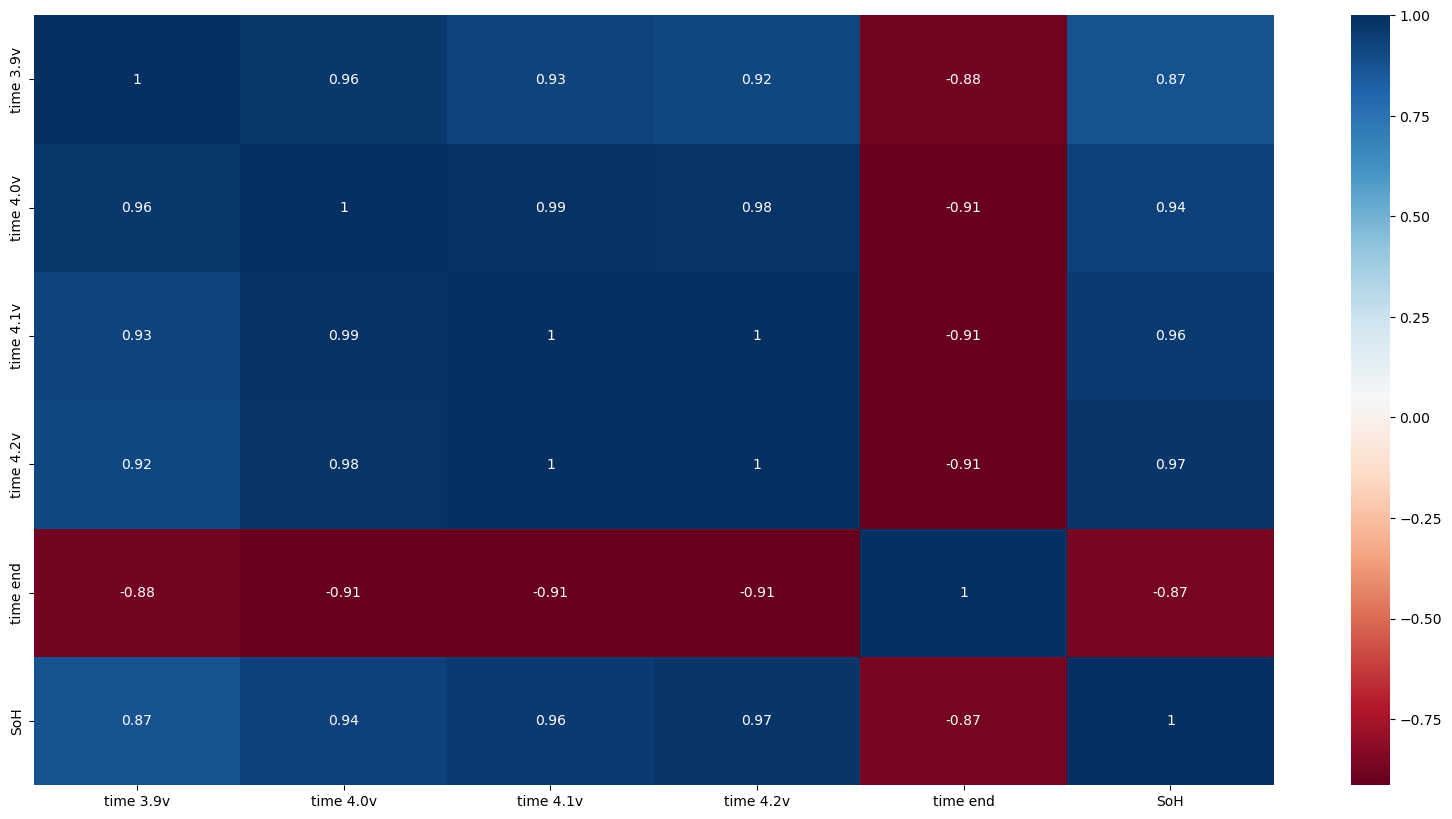

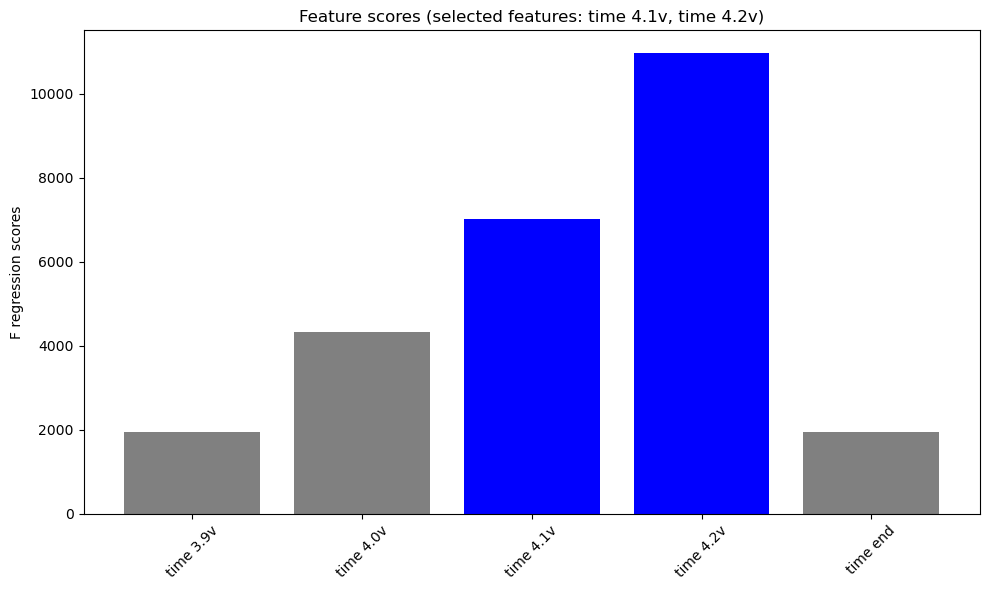

Correlation based selected features: Index(['time 4.1v', 'time 4.2v'], dtype='object')


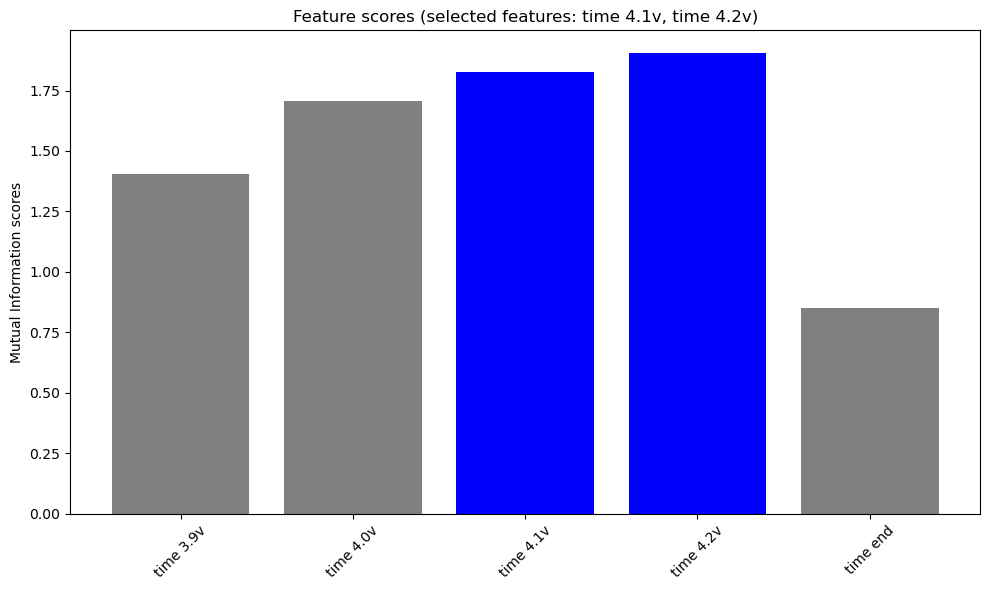

Mutual Information Selected features: Index(['time 4.1v', 'time 4.2v'], dtype='object')


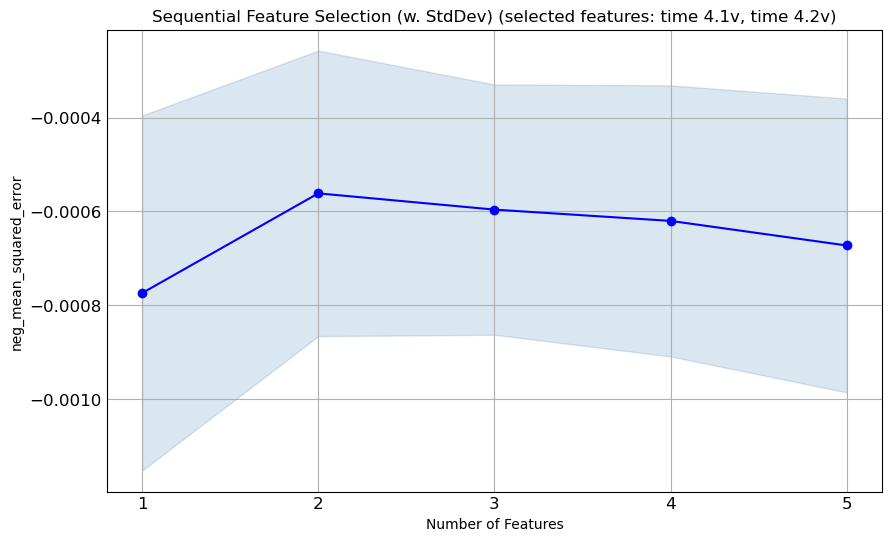

Sequential Feature Selection Features: ['time 4.1v', 'time 4.2v']


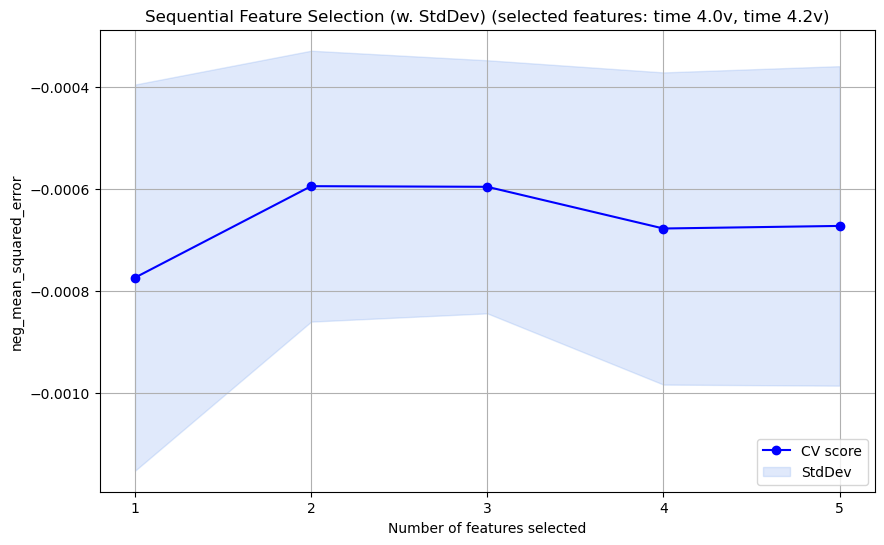

RFECV Features: Index(['time 4.0v', 'time 4.2v'], dtype='object')
Regressor: XGB
Groups: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

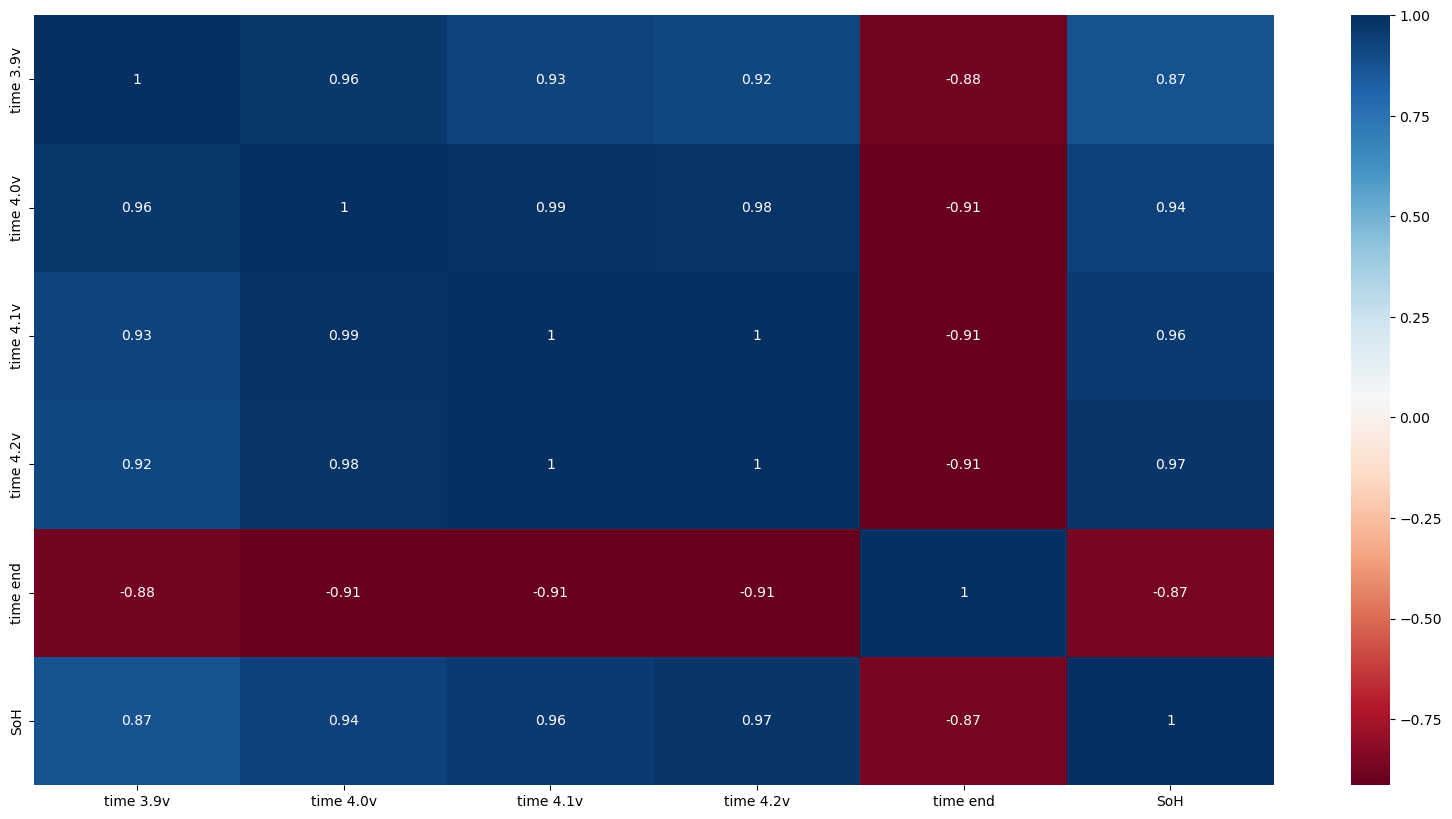

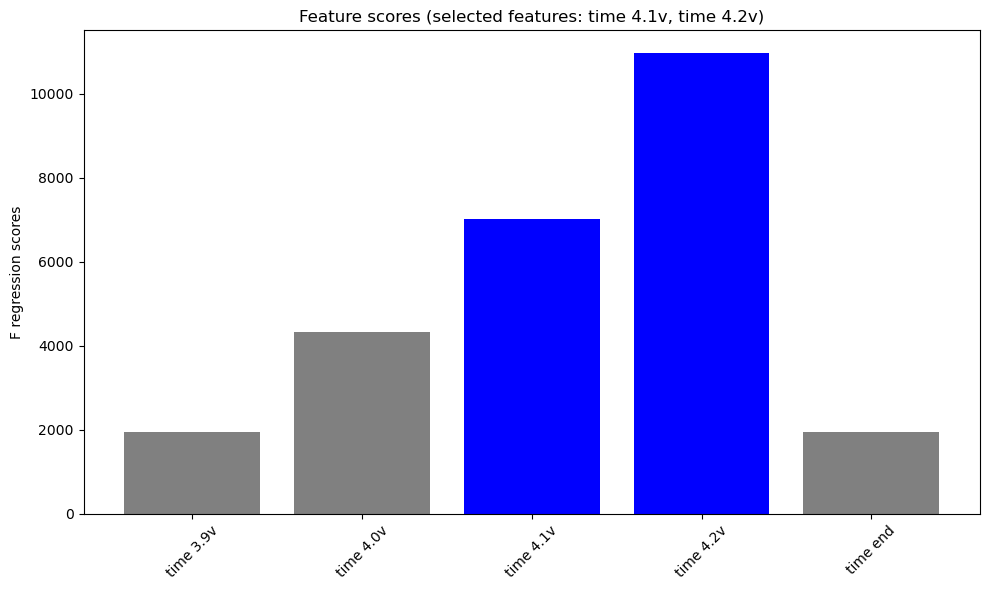

Correlation based selected features: Index(['time 4.1v', 'time 4.2v'], dtype='object')


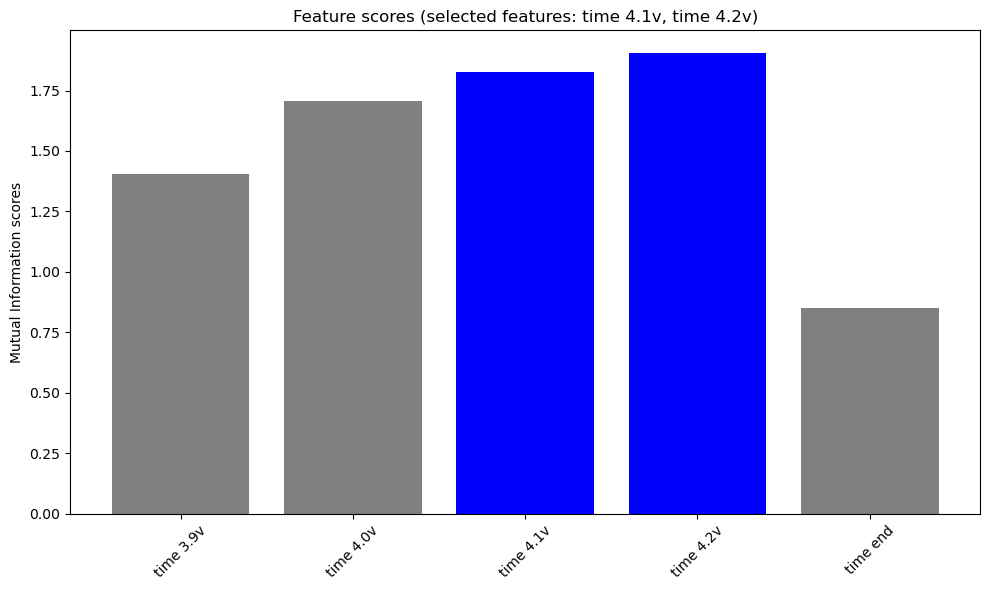

Mutual Information Selected features: Index(['time 4.1v', 'time 4.2v'], dtype='object')


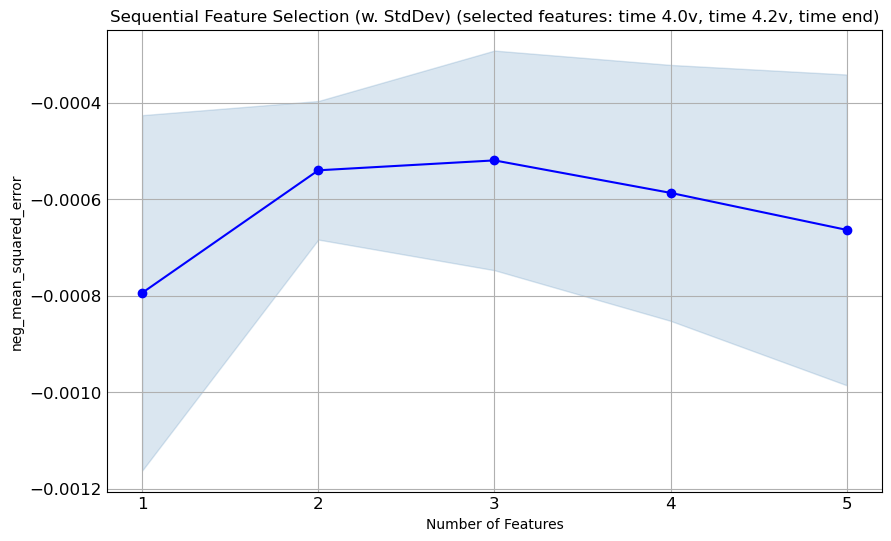

Sequential Feature Selection Features: ['time 4.0v', 'time 4.2v', 'time end']


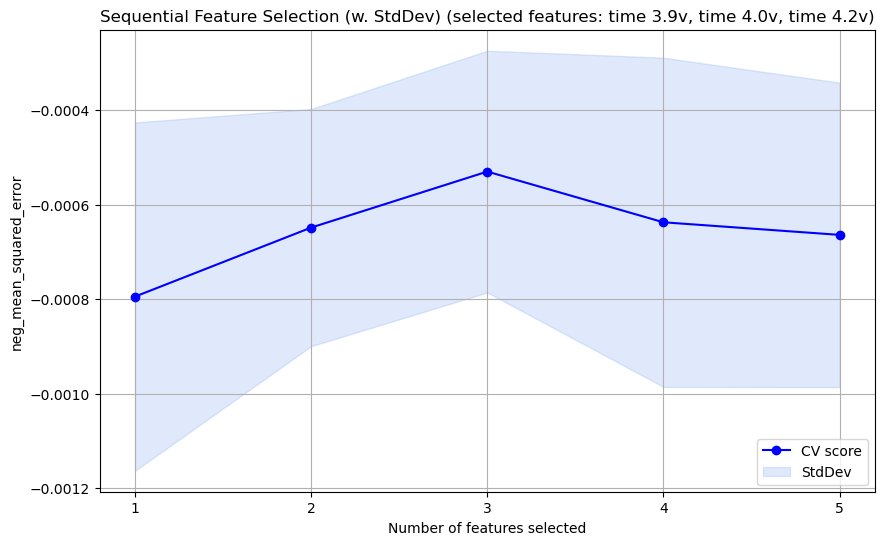

RFECV Features: Index(['time 3.9v', 'time 4.0v', 'time 4.2v'], dtype='object')
Regressor: LGBM
Groups: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

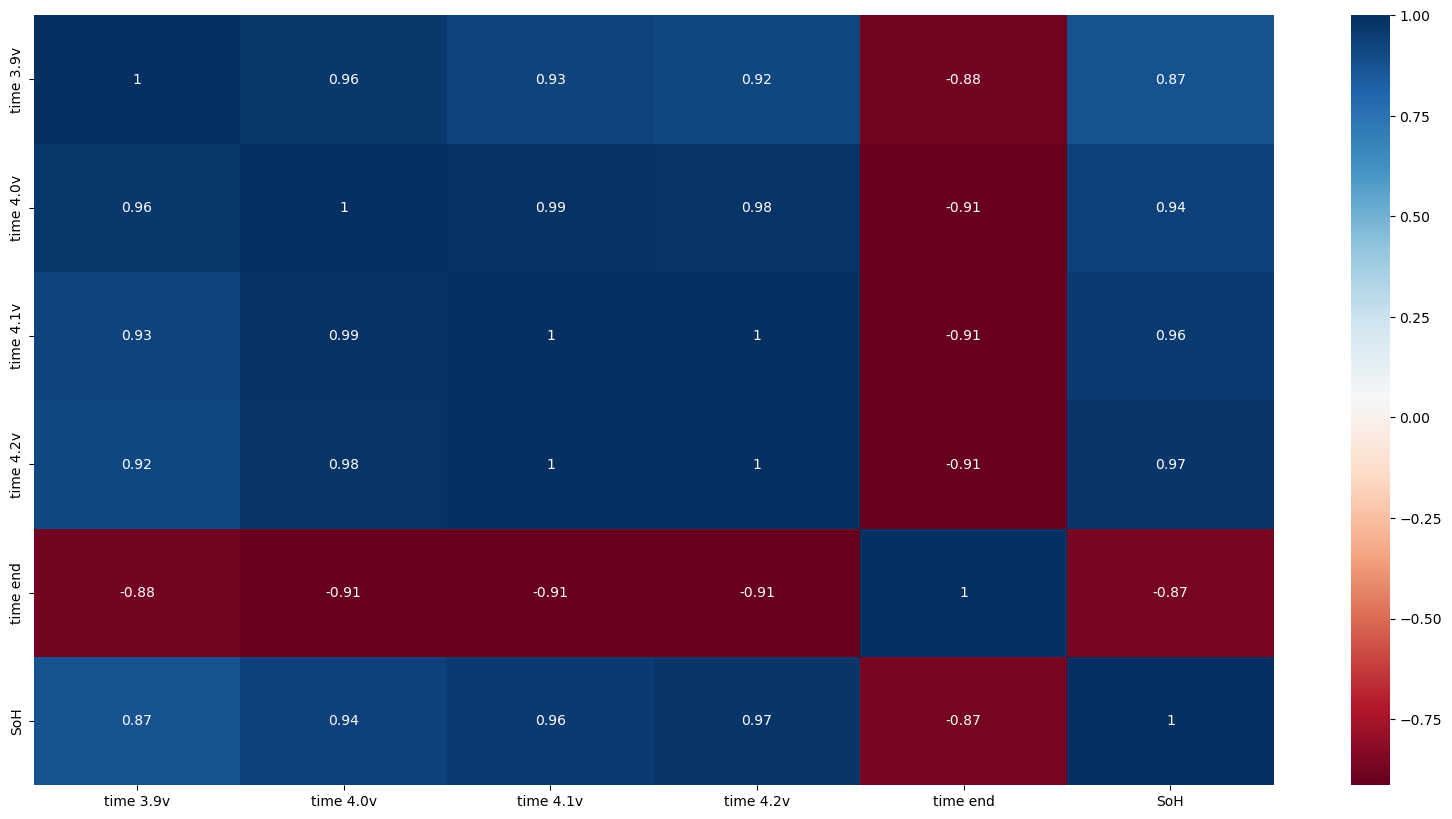

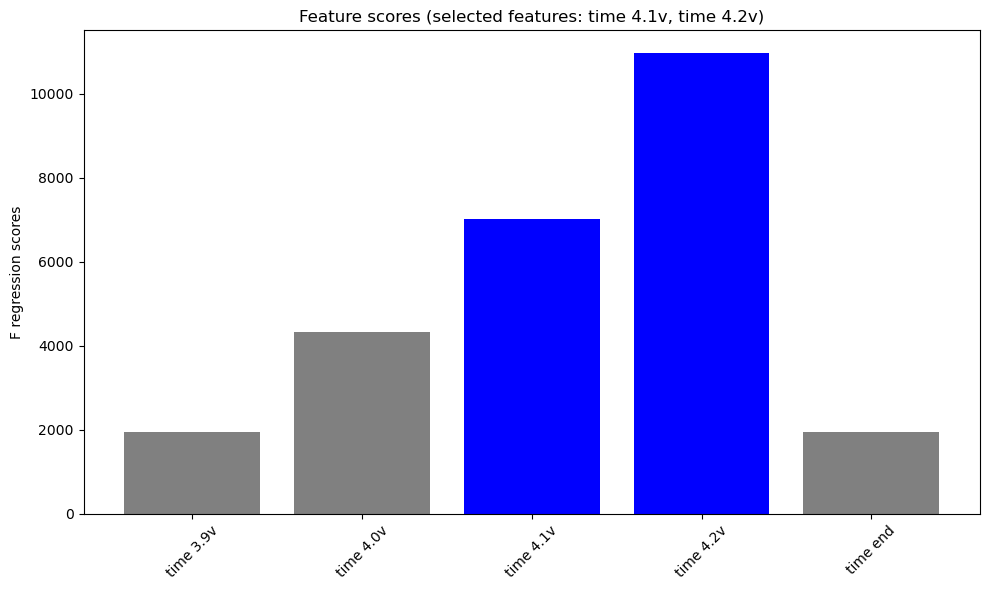

Correlation based selected features: Index(['time 4.1v', 'time 4.2v'], dtype='object')


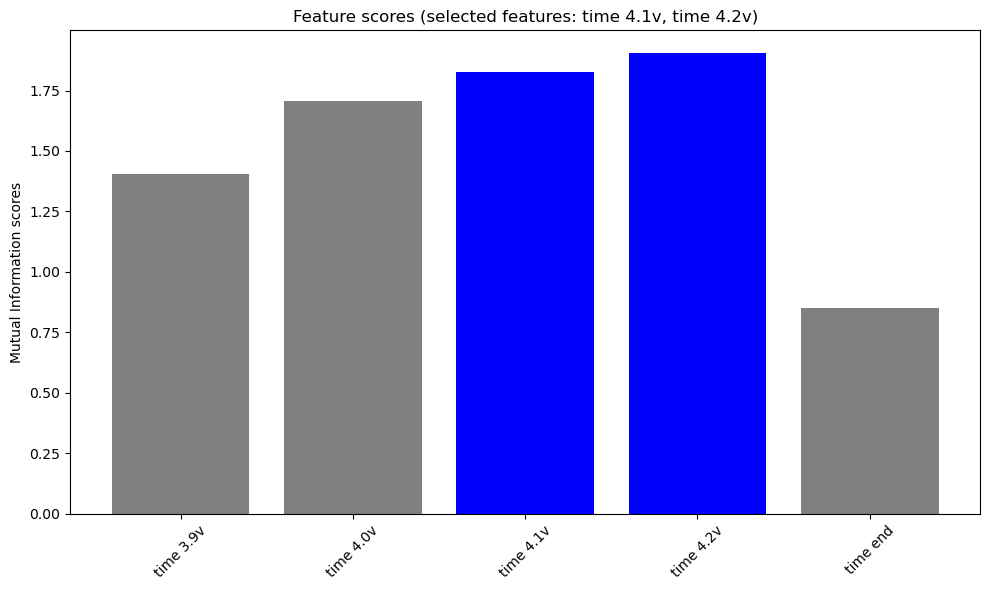

Mutual Information Selected features: Index(['time 4.1v', 'time 4.2v'], dtype='object')


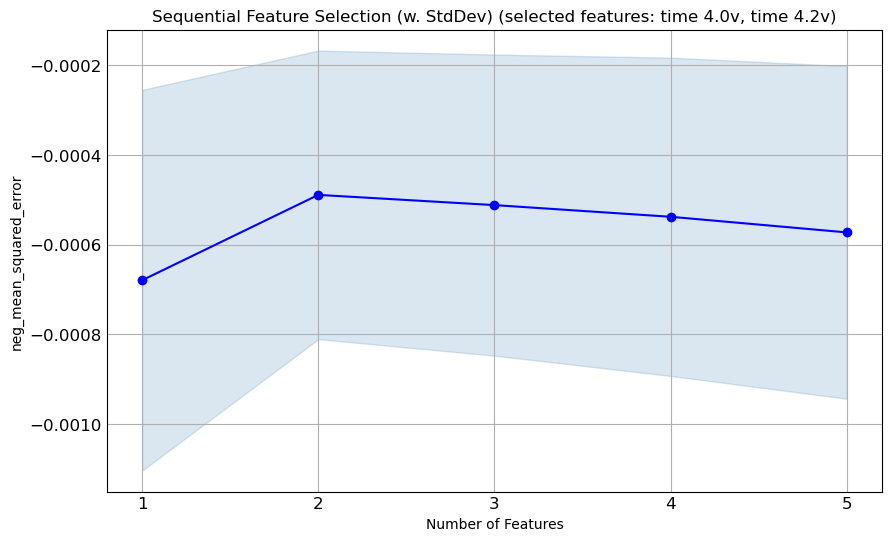

Sequential Feature Selection Features: ['time 4.0v', 'time 4.2v']


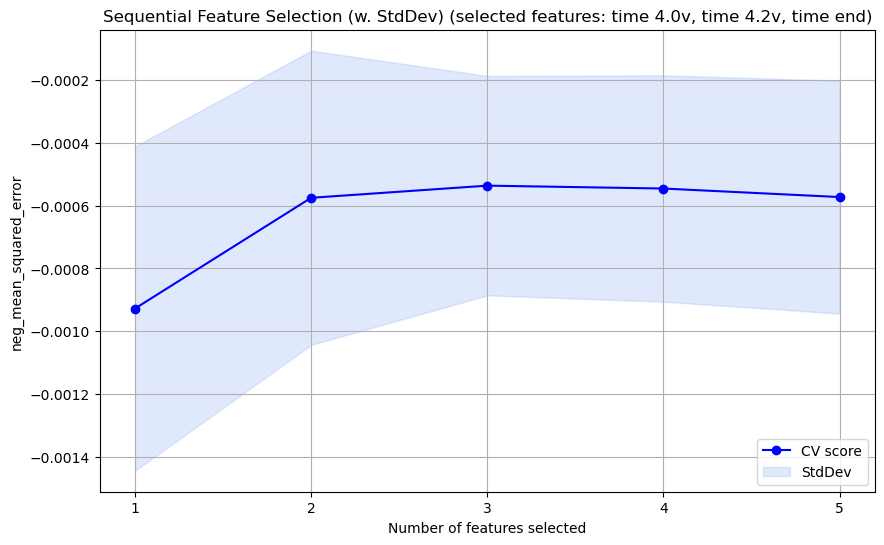

RFECV Features: Index(['time 4.0v', 'time 4.2v', 'time end'], dtype='object')
Regressor: CAT
Groups: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

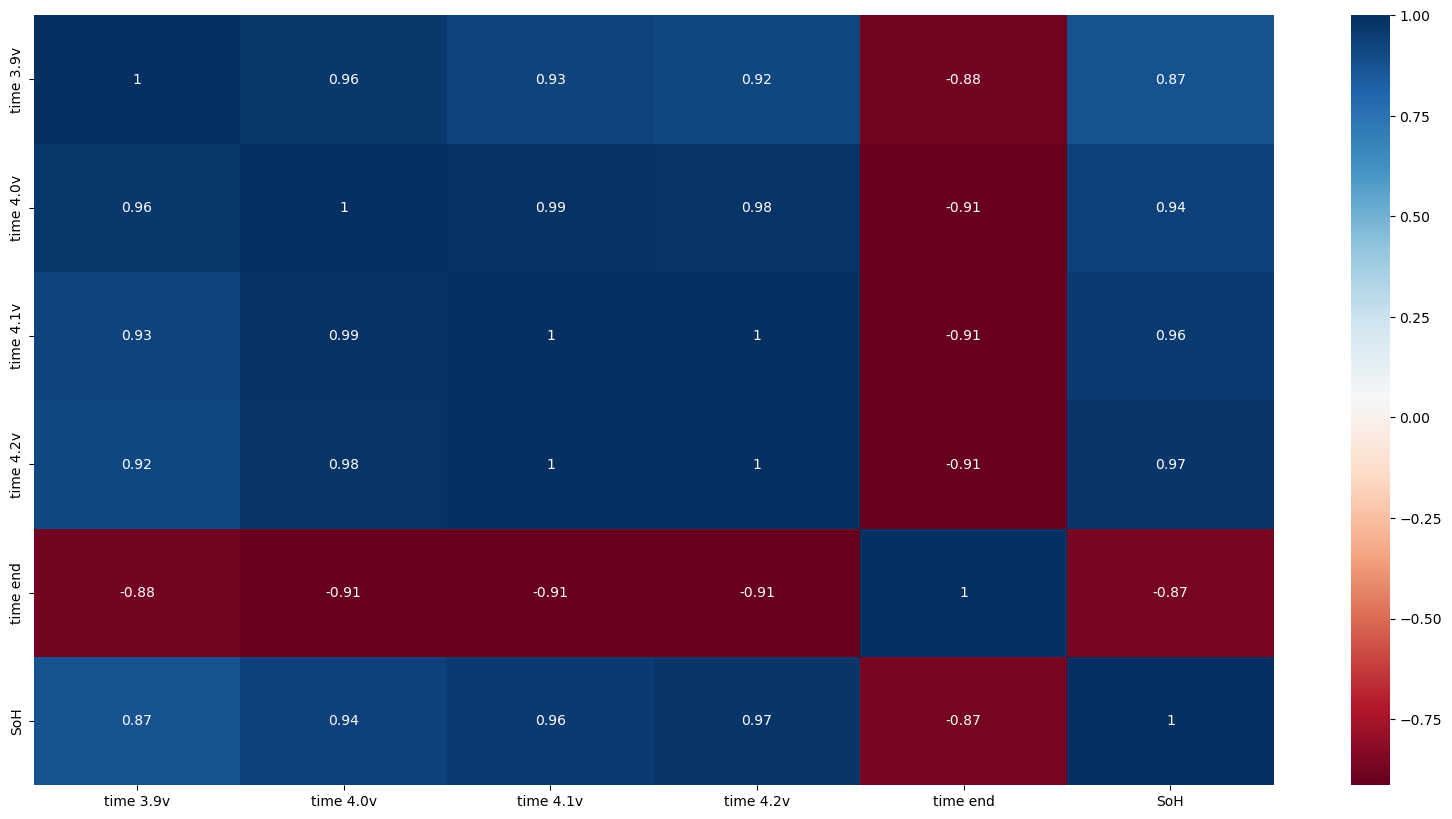

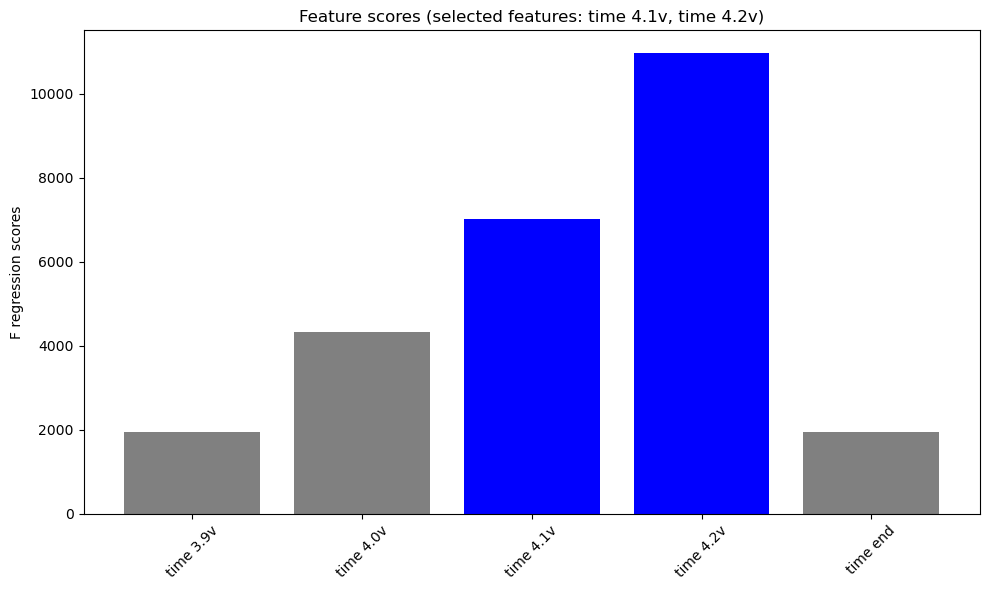

Correlation based selected features: Index(['time 4.1v', 'time 4.2v'], dtype='object')


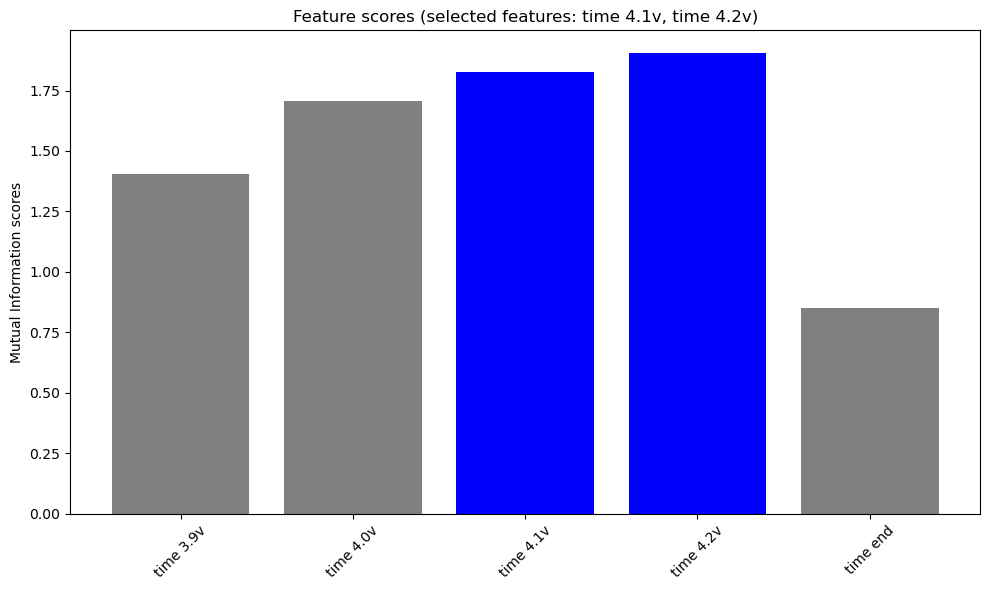

Mutual Information Selected features: Index(['time 4.1v', 'time 4.2v'], dtype='object')


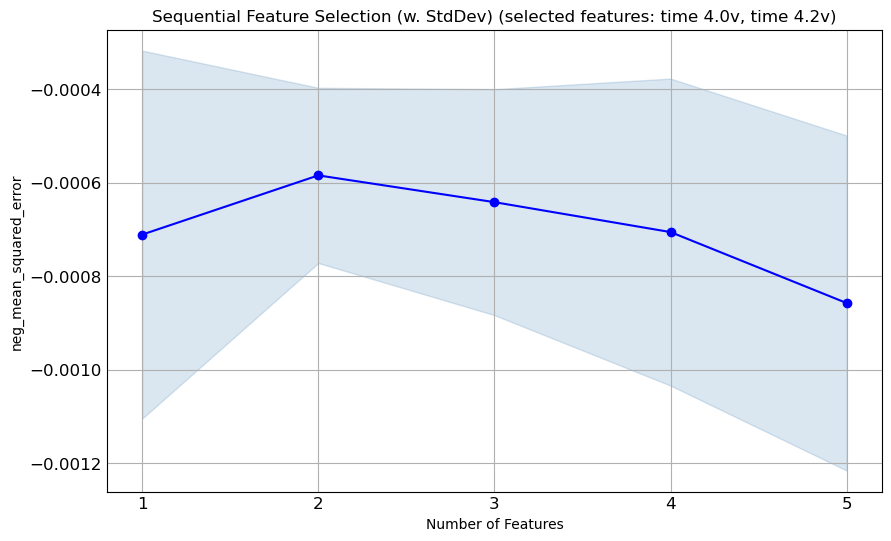

Sequential Feature Selection Features: ['time 4.0v', 'time 4.2v']


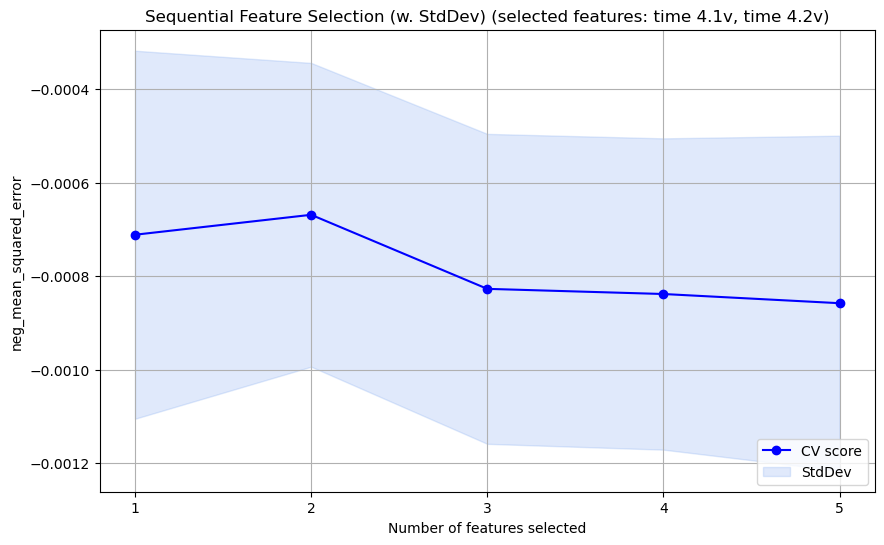

RFECV Features: Index(['time 4.1v', 'time 4.2v'], dtype='object')


In [12]:
regressors = ['RF', 'XGB', 'LGBM', 'CAT']

for regressor in regressors:

    df, groups = load_data()
    print(f'Regressor: {regressor}')
    print(f'Groups: {groups}')
    model = create_model(regressor)
    visualize_corr_heatmap(df, regressor)
    
    corr_features = feature_selection_corr(df, regressor, k=2)
    mi_features = feature_selection_mi(df, regressor, k=2)
    seq_fea_sel_features = feature_selection_sfs(df, regressor, model, groups)
    rfe_cv_features = feature_selection_rfecv(df, regressor, model, groups)

    save_selected_features(regressor, corr_features, mi_features, seq_fea_sel_features, rfe_cv_features)